In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import glob
import os

In [26]:
# Set up data pipelines

DATA_DIR = "data/threecircles_64"

NUM_TRAIN = 10000
NUM_VAL = 1000


def is_consecutive(filenames):
    """Checks if the filenames A and B are consecutive sequences."""
    
    return all(
        A.split('/')[-2] == B.split('/')[-2]
        for A, B in zip(filenames[:-1], filenames[1:])
    )


def get_sliced_filenames(split, history = 5):
    """Returns a function that continiously generates `batch_size` data.
    
    split: 'train', 'val' or 'test'.
    history: number of sequences before to predict for.
    """
    
    # Get filenames.
    filenames = glob.glob(os.path.join(
        DATA_DIR,
        split,
        '**/*.png'
    ), recursive = True)
    
    # Let's pull some 6.006 and make sure our files are in sequence.
    filenames.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
    filenames.sort(key=lambda x: int(x.split('/')[-2]))
    
    if split == 'train':
        filenames = filenames[:NUM_TRAIN]
    else:
        filenames = filenames[:NUM_VAL]
    
    # Slice filenames into consecutive sequences.
    X = []
    y = []
    
    for i in range(len(filenames)):
        # Get a slice of history + 1
        chunk = filenames[i:i+history+1]
        
        if len(chunk) != history + 1:
            continue
        
        if is_consecutive(chunk):
            X.append(chunk[:history])
            y.append(chunk[1:history+1])

    return X, y

In [27]:
# Tensorflow file reader.

BATCH_SIZE = 32
HISTORY = 5
CHANNELS = 1  # It's black and white.
BUFFER_SIZE = 200000
TARGET_SIZE = 64

def get_dataset(split):
    X, y = get_sliced_filenames(split, history = HISTORY)

    def read_png(filename):
        return tf.image.convert_image_dtype(
            tf.image.decode_png(tf.io.read_file(filename), channels=CHANNELS),
            dtype=tf.float32,
        )

    def _parse_function(X, y):
        return (
            tf.map_fn(
                lambda x: read_png(x),
                X, dtype=tf.float32
            ),
            tf.map_fn(
                lambda x: read_png(x),
                y, dtype=tf.float32
            ),
        )

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
    
    return dataset, len(X)

train_dataset, n_train = get_dataset('train')
val_dataset, n_val = get_dataset('val')

In [28]:
# Define and compile model.

model = tf.keras.Sequential()
model.add(tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3),
                                     input_shape=(None, TARGET_SIZE, TARGET_SIZE, 1),
                                     padding='same', return_sequences=True))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3),
                                     padding='same', return_sequences=True))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3),
                                     padding='same', return_sequences=True))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))

model.compile(loss='binary_crossentropy', optimizer='adadelta')

In [55]:
history = model.fit(
    train_dataset,
    epochs=1,
    steps_per_epoch=n_train // BATCH_SIZE,
    validation_steps=n_val // BATCH_SIZE,
    validation_data=val_dataset
)

Train for 309 steps, validate for 30 steps
309/309 [==============================] - 124s 401ms/step - loss: 0.0229 - val_loss: 0.0226


In [48]:
t = 0.5

for x in val_dataset:
    
    frames = []
    
    for f in x[0][30]:
        frames.append(f)
    
    for i in range(10):
        predict = model.predict(np.array([frames[-5:]]))
        im = predict[0][-1].copy()
        im[im <= t] = 0.0
        im[im > t] = 1.0
        frames.append(im)

    break

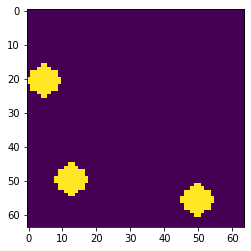

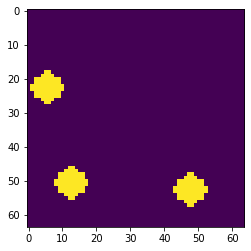

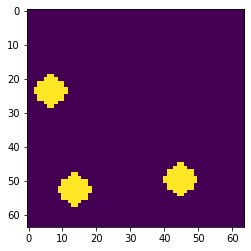

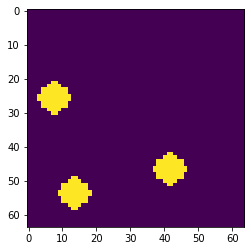

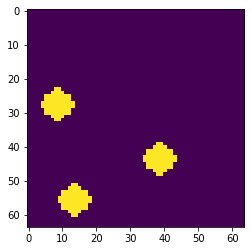

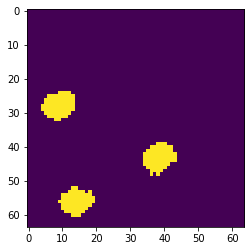

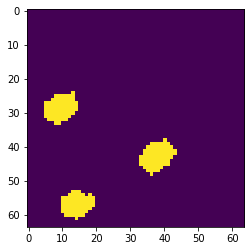

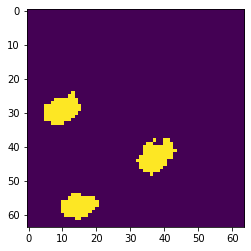

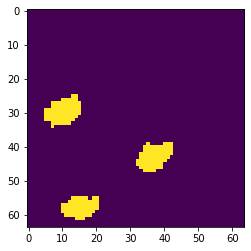

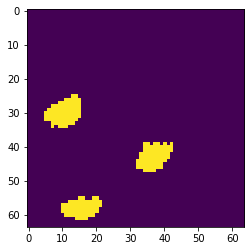

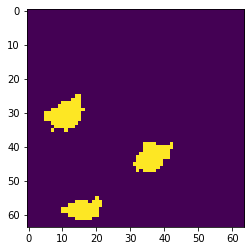

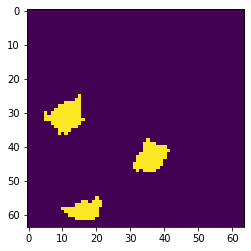

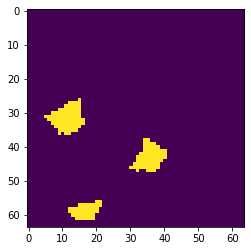

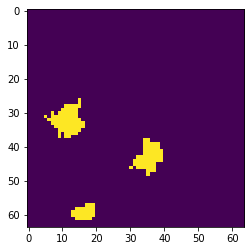

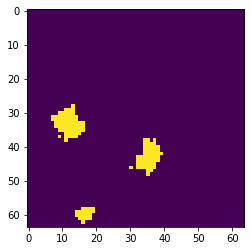

In [49]:
for i, x in enumerate(frames):
    plt.imshow(x[:, :, 0])
    plt.savefig('%i.png' % i)
    plt.show()

In [59]:
for x, y in val_dataset:
    break

In [60]:
p = model.predict(x)

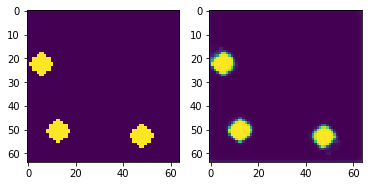

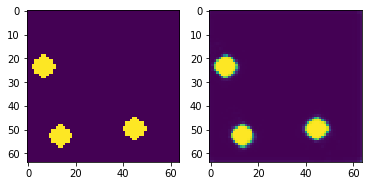

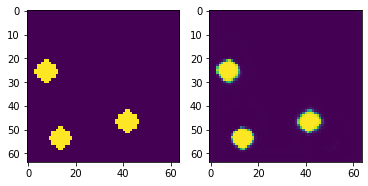

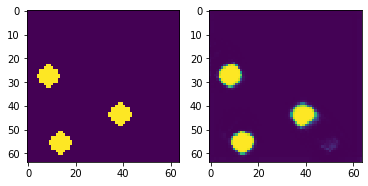

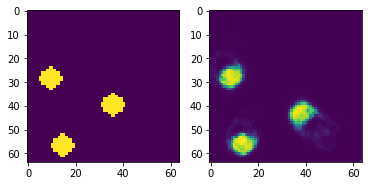

In [61]:
b = 30
for i in range(5):
    fig = plt.figure()
    ax = fig.add_subplot(121)
    plt.imshow(y[b][i][:, :, 0])
    ax = fig.add_subplot(122)
    plt.imshow(p[b][i][:, :, 0])
    plt.show()

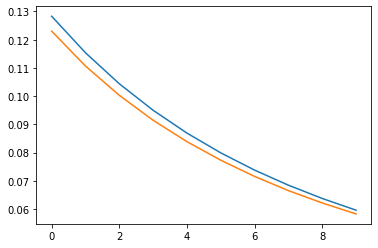

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])